# Task Desription

Please read first the following abstract

## Abstract
                
RNA-Seq reveals an unprecedented complexity of the neuroblastoma transcriptome and is suitable for clinical endpoint prediction [ microarray ]

### Experiment Description  

We generated gene expression profiles from 498 primary neuroblastomas using RNA-Seq and microarrays. We sought to systematically evaluate the capability of RNA deep-sequencing (RNA-Seq)-based classification for clinical endpoint prediction in comparison to microarray-based ones. The neuroblastoma cohort was randomly divided into training and validation sets (**Please note:** <em>in the following we refer to this validation set as test set</em>), and 360 predictive models on six clinical endpoints were generated and evaluated. While prediction performances did not differ considerably between the two technical platforms, the RNA-Seq data processing pipelines, or feature levels (i.e., gene, transcript, and exon junction levels), RNA-Seq models based on the AceView database performed best on most endpoints. Collectively, our study reveals an unprecedented complexity of the neuroblastoma transcriptome, and provides guidelines for the development of gene expression-based predictive classifiers using high-throughput technologies.  Sample clinical characteristics definitions:  

* sex: 
    <ul>
    <li>M = male</li>
    <li>F = female</li>
    </ul>
    
* age at diagnosis: The age in days at diagnosis 
    <ul>
    <li>integer</li>
    </ul>

* high risk: Clinically considered as high-risk neuroblastoma
    <ul>
    <li>yes = 1</li>
    <li>no = 0</li>
    </ul>


* INSS stage: Disease stage according to International Neuroblastoma Staging System ([INSS](https://www.cancer.org/cancer/neuroblastoma/detection-diagnosis-staging/staging.html)) 
    <ul>
    <li>1</li>
    <li>2</li>
    <li>3</li>
    <li>4</li>
    <li>4S</li>
    </ul>


* progression: Occurrence of a tumor progression event
    <ul>
    <li>yes = 1</li>
    <li>no = 0</li>
    </ul>



* death from disease: Occurrence of death from the disease (yes=1; no=0) 
    <ul>
    <li>yes = 1</li>
    <li>no = 0</li>
    </ul>





Gene expression of 498 neuroblastoma samples was quantified by RNA sequencing as well as by microarray analyses in order to understand the neuroblastoma transcriptome and predict clinical endpoints. 


## Task

The task is to predict the missing values in the validation set (from here on called test set). Do this either with the RNASeq or the Microarray data, or potentially both?



## Code

To make your start a bit easier, here is a small notebook reading the data in. It finishes with a function enabling you to save your predictions for submission. 

#### from here, the code starts

First some imports 

In [354]:
#DATA MANIPULATION
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer

#PLOTTING AND VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

#SCALING AND NORMALISATION
from sklearn.preprocessing import MinMaxScaler, RobustScaler

#FEATURE SELECTION
from sklearn.feature_selection import SelectKBest, chi2

#CLASSIFIERS
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

#MODEL SELECTION
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

#PCA AND CLUSTERING
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

### Setting  up directory and filenames

In [355]:
fn_fpkm             = 'log2FPKM.tsv' #rnaseq
fn_patient_info     = 'patientInfo.tsv' #patientdata
fn_prop_intensities = 'allProbIntensities.tsv' #microarray


### Load the RNAs-Seq data

This part already sets the indeces in the DataFrame. Please feel free to change as required. 

In [356]:
df_fpkm = pd.read_csv(fn_fpkm,sep='\t').rename({'00gene_id':'gene_id'},axis=1)
df_fpkm = df_fpkm.set_index(['gene_id'])
df_fpkm.columns.name = 'ID'

df_fpkm.head()

ID,NB001,NB002,NB003,NB004,NB005,NB006,NB007,NB008,NB009,NB010,...,NB489,NB490,NB491,NB492,NB493,NB494,NB495,NB496,NB497,NB498
gene_id,,,,,,,,,,,,,,,,,,,,,
1/2-SBSRNA4,0.834381,0.743094,0.909414,0.795775,0.905540,0.869154,1.811352,0.599240,0.981855,1.066399,...,0.997977,1.003559,0.842437,1.057873,0.805515,0.491331,0.868249,0.911379,0.660139,1.152988
A1BG,1.910053,0.941996,1.950857,1.989477,1.942946,1.927608,1.617745,2.161291,1.436439,2.159797,...,2.336929,2.836360,1.205317,2.439868,1.649027,1.451425,1.493852,1.641241,1.994978,1.289534
A1BG-AS1,1.453191,0.640614,1.156765,1.525277,1.365043,0.899212,1.304178,1.189205,0.771248,1.114787,...,1.182908,1.367371,0.643751,1.096815,0.925425,0.933275,1.208723,0.904511,1.529221,1.102866
A1CF,0.005102,0.005902,0.005192,0.000000,0.025347,0.005682,0.000000,0.000000,0.021880,0.000000,...,0.024298,0.007295,0.000000,0.006678,0.005746,0.004998,0.004853,0.000000,0.022780,0.018720
A2LD1,0.580151,0.738233,0.927667,0.936497,0.924853,0.739038,1.018705,0.546324,0.666877,0.865850,...,0.673627,1.401265,0.837443,0.939849,0.743496,0.957837,0.812093,0.488748,1.068072,0.782887


### Load the Microarray data

This part already sets the indeces in the DataFrame. Please feel free to change as required. 

In [357]:
df_prop_intensities = pd.read_csv(fn_prop_intensities,sep='\t').set_index(['Reporter.Identifier'])
df_prop_intensities.columns.name = 'ID'

df_prop_intensities.head()

ID,GeneSymbols,NB001,NB002,NB003,NB004,NB005,NB006,NB007,NB008,NB009,...,NB489,NB490,NB491,NB492,NB493,NB494,NB495,NB496,NB497,NB498
Reporter.Identifier,,,,,,,,,,,,,,,,,,,,,
28913,NaN,14.99,14.94,12.48,14.63,11.89,15.09,13.07,12.00,11.70,...,13.62,13.03,14.98,13.36,13.90,13.00,13.79,14.70,14.03,12.31
27262,NaN,9.20,10.41,9.27,8.83,7.97,10.33,9.62,8.72,9.36,...,6.26,5.93,6.97,5.99,7.62,7.76,8.56,7.74,7.57,7.08
3180,NaN,5.06,5.26,6.45,2.89,2.00,4.80,3.05,6.39,6.43,...,0.93,0.58,1.26,1.38,3.49,2.07,2.26,2.29,2.63,2.54
41426,MBL1P,7.45,8.68,6.30,7.30,6.26,7.50,7.43,6.98,8.02,...,5.35,5.57,5.51,6.30,6.60,6.38,7.49,6.77,8.13,7.11
37033,NaN,6.74,6.63,6.75,6.20,6.57,6.01,6.78,4.80,5.15,...,4.58,4.61,3.54,4.55,4.20,7.16,7.07,5.07,6.28,6.34


### Load the patient factors, including the potential endpoints 

This part already sets the indeces in the DataFrame. Please feel free to change as required. 
Please note, that the ```FactorValues``` should have a 1-to-1 correspondence to the factors desc ribed in the abstract. 

In [358]:
df_patient_info = pd.read_csv(fn_patient_info,sep='\t').set_index('ID')
df_patient_info.columns.name = 'FactorValues'

####  Divide into training and external testing

As you might have already noticed, we removed some of the factor values for some of the patient **ID**s.
Every row, where this information is missing indicate a real validation entry. We can use this information and create two separate DataFrames, one for training, one for the validation (testing). 

The task is to predict the missing values, either with the RNASeq or the Microarray data, or potentially both?



In [359]:
df_patient_info_train  = df_patient_info[df_patient_info['FactorValue..death.from.disease.'].notna()]
df_patient_info_test   = df_patient_info[df_patient_info['FactorValue..death.from.disease.'].isna()]

#### Checking how many classes for each column we are trying to predict

In [360]:
count_NaN= df_patient_info_test['FactorValue..Sex.'].isnull().values.any() #FALSE(none)
count_NaN_age= df_patient_info_test['FactorValue..age.at.diagnosis.'].isnull().values.any() #FALSE(none)
count_NaN_death= df_patient_info_test['FactorValue..death.from.disease.'].isnull().sum() #249
count_NaN_risk= df_patient_info_test['FactorValue..high.risk.'].isnull().sum() #249
count_NaN_INSS= df_patient_info_test['FactorValue..inss.stage.'].isnull().sum() #249
count_NaN_prog= df_patient_info_test['FactorValue..progression.'].isnull().sum() #249

In [361]:
df_patient_info_train.head()

FactorValues,FactorValue..Sex.,FactorValue..age.at.diagnosis.,FactorValue..death.from.disease.,FactorValue..high.risk.,FactorValue..inss.stage.,FactorValue..progression.
ID,,,,,,
NB497,female,379,0.0,0.0,1,0.0
NB495,male,163,0.0,0.0,1,0.0
NB493,male,190,0.0,0.0,1,0.0
NB491,male,2326,0.0,1.0,4,1.0
NB489,female,865,0.0,1.0,4,0.0


In [362]:
df_patient_info_test.head()

FactorValues,FactorValue..Sex.,FactorValue..age.at.diagnosis.,FactorValue..death.from.disease.,FactorValue..high.risk.,FactorValue..inss.stage.,FactorValue..progression.
ID,,,,,,
NB498,female,530,NaN,NaN,NaN,NaN
NB496,male,132,NaN,NaN,NaN,NaN
NB494,male,56,NaN,NaN,NaN,NaN
NB492,male,947,NaN,NaN,NaN,NaN
NB490,female,1759,NaN,NaN,NaN,NaN


## Analysis

From here on, you will need to use your skills ...

Some useful hints :
1. Exploratory analysis to better understand the data.
2. You might want to investigate trends and patters in data through some unsupervised learning.
3. When training a predictive model (aka known as classifiers) evaluate your model training performance using cross validation.
4. predictive performance metrics


### Note:
To be clear, there are **multiple** target features/attributes to predict. Say you want to build a model predicting **death from disease** of a patient, your target variable is ```'FactorValue..death.from.disease.'``` and the corresponding target vector <em>y</em> would be as follows:

```python
y_train = df_patient_info_train['FactorValue..death.from.disease.'].astype(int)
```
Taking the other data into account (RNASeq or microarray) as ``` X_train``` (you will have to preprocess and split this information yourselves), you could for example build a random forest model:

```python
from sklearn.ensemble import RandomForestClassifier
random_f_model_death = random_f_model = RandomForestClassifier() 
random_f_model_death.fit(X_train,y_train)
```
and predict ```y_test``` using ```X_test```. 

Obviously, you want to avoid any overfitting and might want to use appropriate validation approaches. 

Once you have your model and the prediction for the test data, you should be able to fill the ```'FactorValue..death.from.disease.'``` column in the test set. 

For the submission, please also include the confidence/probability/score for each of the prediction (assume ```1``` to be the value for the positive class). This only applies to the factors:  **high risk**, **progression** and **death from disease** . 

The other two factors need to be treated differently.  

Using this very rough outline, you should be able to predict all factors in the test data. 











# 1. Inspecting the data
### Understanding the data and variables
 - Describe
 - Info
 - Transpose (to replicate Y data) & rename
 - Make a copy of the dataframe so we always have the original to refer back to if need be

In [363]:
df_fpkm

ID,NB001,NB002,NB003,NB004,NB005,NB006,NB007,NB008,NB009,NB010,...,NB489,NB490,NB491,NB492,NB493,NB494,NB495,NB496,NB497,NB498
gene_id,,,,,,,,,,,,,,,,,,,,,
1/2-SBSRNA4,0.834381,0.743094,0.909414,0.795775,0.905540,0.869154,1.811352,0.599240,0.981855,1.066399,...,0.997977,1.003559,0.842437,1.057873,0.805515,0.491331,0.868249,0.911379,0.660139,1.152988
A1BG,1.910053,0.941996,1.950857,1.989477,1.942946,1.927608,1.617745,2.161291,1.436439,2.159797,...,2.336929,2.836360,1.205317,2.439868,1.649027,1.451425,1.493852,1.641241,1.994978,1.289534
A1BG-AS1,1.453191,0.640614,1.156765,1.525277,1.365043,0.899212,1.304178,1.189205,0.771248,1.114787,...,1.182908,1.367371,0.643751,1.096815,0.925425,0.933275,1.208723,0.904511,1.529221,1.102866
A1CF,0.005102,0.005902,0.005192,0.000000,0.025347,0.005682,0.000000,0.000000,0.021880,0.000000,...,0.024298,0.007295,0.000000,0.006678,0.005746,0.004998,0.004853,0.000000,0.022780,0.018720
A2LD1,0.580151,0.738233,0.927667,0.936497,0.924853,0.739038,1.018705,0.546324,0.666877,0.865850,...,0.673627,1.401265,0.837443,0.939849,0.743496,0.957837,0.812093,0.488748,1.068072,0.782887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.862512,0.051655,0.022912,0.108028,0.049621,0.264942,0.044684,0.000000,0.012183,0.021898,...,0.026980,0.094324,0.780477,0.043928,0.025368,0.011083,0.000000,0.070668,0.022501,0.031067
ZYG11B,3.561729,3.595790,2.236695,3.312516,2.235632,3.459969,3.130989,2.359791,2.361504,3.284610,...,2.827654,2.569946,3.569224,2.773570,3.690249,3.274257,3.380637,3.420162,3.462327,3.440527
ZYX,5.039327,5.144157,4.982975,6.142091,5.236531,6.108395,5.645258,5.018567,5.393207,5.730512,...,5.103993,4.754433,4.938587,4.572914,4.877509,5.591545,5.207842,5.346003,5.427338,5.148169


In [364]:
df_fpkm.describe()

ID,NB001,NB002,NB003,NB004,NB005,NB006,NB007,NB008,NB009,NB010,...,NB489,NB490,NB491,NB492,NB493,NB494,NB495,NB496,NB497,NB498
count,23146.000000,23146.000000,23146.000000,23146.000000,23146.000000,23146.000000,23146.000000,23146.000000,23146.000000,23146.000000,...,23146.000000,23146.000000,23146.000000,23146.000000,23146.000000,23146.000000,23146.000000,23146.000000,23146.000000,23146.000000
mean,2.131786,2.031470,1.982196,2.099646,2.003848,2.011317,2.096597,1.920999,2.065478,1.986630,...,1.920203,2.024646,2.047632,1.992819,2.002479,2.054730,2.064404,2.016765,2.051336,2.104204
std,1.951392,1.971386,1.968145,1.993527,1.943513,1.975446,1.937307,1.968883,2.017544,2.016251,...,1.926518,2.047764,2.006113,1.926888,1.966683,1.978456,1.960457,1.964566,1.927895,1.927567
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.117889,0.083477,0.055345,0.087390,0.078837,0.055772,0.116028,0.043383,0.086224,0.051249,...,0.050910,0.047880,0.071446,0.083381,0.053790,0.079285,0.084918,0.076877,0.095710,0.129845
50%,1.978968,1.682904,1.611080,1.846068,1.717048,1.670781,1.917371,1.472477,1.699238,1.511961,...,1.544990,1.647250,1.712686,1.721878,1.634305,1.767362,1.813757,1.681775,1.840993,1.938244
75%,3.582427,3.516214,3.414691,3.587926,3.389331,3.498391,3.513794,3.357375,3.542357,3.475403,...,3.305106,3.446130,3.480860,3.378446,3.487406,3.482403,3.508283,3.447391,3.452575,3.516920
max,13.201288,12.664172,13.915674,11.866379,13.486936,12.584354,11.005814,15.514942,13.823188,14.112179,...,12.374550,13.633097,11.191732,14.084759,13.527550,15.841282,15.281579,15.791583,15.669098,11.221629


In [365]:
df_fpkm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23146 entries, 1/2-SBSRNA4 to ZZZ3
Columns: 498 entries, NB001 to NB498
dtypes: float64(498)
memory usage: 88.1+ MB


In [366]:
df_rnaseq = df_fpkm.T

In [367]:
rnaseq_copy = pd.DataFrame(df_rnaseq)

# 2. Splitting the data
 - Rename the RNASeq index (cut to first 5 characters to replicate Y data)
 - Split the X data based on the samples that are present in Y data
 - Split X data into test and train (this will be a 50/50 split with 249 rows)
 - Rename Y data & split by column
 - This is not the most conventional way to split data, however it was done in this way to ensure samples were matched in X and labelled data

### X Data (RNASeq)

In [368]:
renamed = rnaseq_copy.rename(index=lambda x: x[0:5], inplace=True)
rna_index = rnaseq_copy.index
patient_index = df_patient_info_train.index
rnalist = rna_index.tolist()
patientlist = patient_index.tolist()
differences = list(set(rnalist).symmetric_difference(set(patientlist)))

In [369]:
X_train = rnaseq_copy.drop(differences)
X_test = rnaseq_copy.drop(X_train.index)

### Y Data (labels and NAs for prediction)
 - This data has been previously been split by NA and non-NA, this was a 50/50 split
 - INSS is the only multi-class problem, the rest are binary

In [370]:
y_train = df_patient_info_train['FactorValue..death.from.disease.'].astype(int)
y_test = df_patient_info_test['FactorValue..death.from.disease.']

In [371]:
y_train_highrisk = df_patient_info_train['FactorValue..high.risk.'].astype(int)
y_test_highrisk = df_patient_info_test['FactorValue..high.risk.']

In [372]:
y_train_INSS = df_patient_info_train['FactorValue..inss.stage.']
y_test_INSS = df_patient_info_test['FactorValue..inss.stage.']

In [373]:
y_train_prog = df_patient_info_train['FactorValue..progression.'].astype(int)
y_test_prog = df_patient_info_test['FactorValue..progression.']

# 3. Data Cleaning
 - Check for NA
 - Imputation if necessary
 - Manual feature slection (remove genes with no expression) - genes with very low counts across provide little evidence for differential expression and they interfere with some of the statistical approximations that are used later in the pipeline. The filtering of low-expression genes is a common practice in the analysis of RNA-seq data. 


In [374]:
nullvalues = X_train.isnull().values.sum()
nullvalues

0

In [375]:
#Remove genes with low counts - more that 25% of the column is 0.000000
df_expressed = X_train.replace(0, np.nan)
NaN_percentage = df_expressed.isna().sum()/df_expressed.shape[0]*100
cols_to_drop = NaN_percentage[NaN_percentage>25].keys()
df_expressed_genes = df_expressed.drop(cols_to_drop, axis =1)
df_rnaseq_dropped = df_expressed_genes.replace(np.nan, 0)


# 4. Data Preparation
 - Scaling the data

In [376]:
scaler = MinMaxScaler()
scaler.fit_transform(X_train)

array([[0.35308121, 0.14315764, 0.3526754 , ..., 0.50996706, 0.67769992,
        0.59401643],
       [0.39249957, 0.14854644, 0.26431023, ..., 0.49235748, 0.49518159,
        0.24377544],
       [0.39046472, 0.14750172, 0.32639827, ..., 0.5715921 , 0.43570196,
        0.1607602 ],
       ...,
       [0.33791612, 0.10868435, 0.1953469 , ..., 0.45939978, 0.53077686,
        0.59263424],
       [0.37087369, 0.08819074, 0.27979897, ..., 0.56262702, 0.6710798 ,
        0.55777559],
       [0.26154313, 0.15437346, 0.37534023, ..., 0.6312182 , 0.60859283,
        0.65479822]])

In [377]:
#dataframes with scaled data
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                              columns=X_train.columns,index=X_train.index)

# 5. Visualisation (Unsupervised)


## PCA Analysis
 - Principal Component Analysis
 - Clustering method
 - Dimensionality reduction (reducing info from thousands of genes to only two dimensions)
 - Points on plots are related to gene expression, but not of a single gene
 - Imagine a "meta" gene, with each point representing a linear combination of many (thousands) genes
 
### Select Number of Prinicipal Components
 - The percentage of the explained variance is: explained_variance_ratio_ (The sum of the rations will be equal to one
 - if there is deviation from one, then the remainder is stored in the other components of the original feature space)
 - The variance (eighenvalues) of the covariance matrix is: explained_variance_
 - Here we can use explained_variance_ratio_ to determine how many PCs we need to explain X% of the variance

Text(0, 0.5, 'Cumulative Explained Variance (Percentage)')

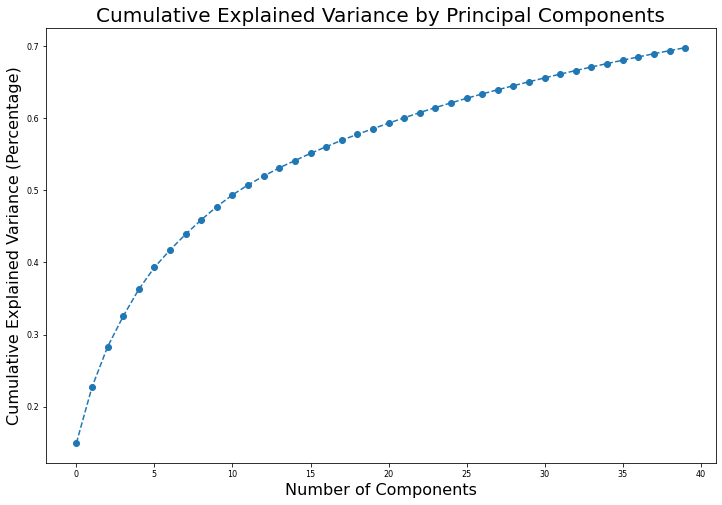

In [379]:
pca_select = PCA(n_components=50)
pca_select.fit_transform(X_train_scaled)

array = pca_select.explained_variance_ratio_
top20array = array[:40]

plt.figure(figsize = (12,8))
plt.plot(range(0,40), top20array.cumsum(), marker = 'o', linestyle = '--')
plt.title('Cumulative Explained Variance by Principal Components', fontsize=20)
plt.xlabel('Number of Components', fontsize=16)
plt.ylabel('Cumulative Explained Variance (Percentage)', fontsize=16)

### Applying PCA and creating data frame
 - It is claer from the scree plot that we would need approxiately 40 PCs to reach 70%, a rule of thumb is that 80% should be the minimum in order to provide accuracy
 - We can use the first two Principal Components to visualise the data 2-dimensionally

In [380]:
pca = PCA(n_components=2)
pca.fit_transform(X_train_scaled)

# store in a new dataframe for simpler plotting
df_rnaseq_pca = pd.DataFrame(pca.transform(X_train_scaled),index=X_train_scaled.index,columns=['PCA 1','PCA 2'])
pca_and_target = pd.concat([df_rnaseq_pca, y_train], axis=1, join='inner')
pca_and_target['Label'] = np.where(pca_and_target['FactorValue..death.from.disease.'] == 1, '1', '0')
pca_df = pca_and_target.rename(columns={'FactorValue..death.from.disease.': 'Target'})

### Plotting the first two principal components (Death from Disease)

In [381]:
pca_variance = pca.explained_variance_ratio_.tolist()
pca_variance[0] = pca_variance[0]*100
pca_variance[1] = pca_variance[1]*100
pca1lab = "PC 1" + ", " + str(round(pca_variance[0], 2)) + "%"
pca2lab = "PC 2" + ", " + str(round(pca_variance[1], 2)) + "%"

Text(0, 0.5, 'PC 2, 7.75%')

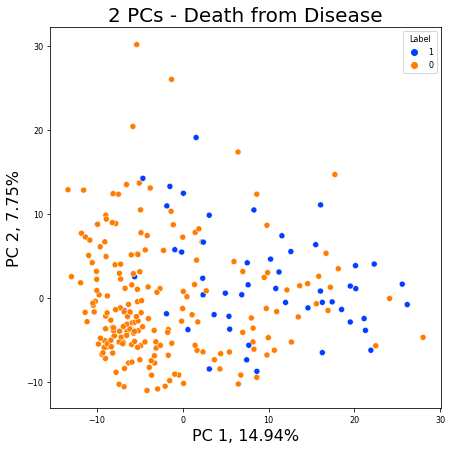

In [382]:
plt.figure(figsize = (7, 7))
ax = sns.scatterplot(x="PCA 1", y="PCA 2", hue= "Label", data=pca_df, palette="bright")
plt.title("2 PCs - Death from Disease", fontsize=20)
plt.xlabel(pca1lab, fontsize=16)
plt.ylabel(pca2lab, fontsize=16)

### Plotting the first two principal components (INSS stage)

In [384]:
# store in a new dataframe for simpler plotting
pca_and_target_INSS = pd.concat([df_rnaseq_pca, y_train_INSS], axis=1, join='inner')
pca_df_INSS = pca_and_target_INSS.rename(columns={'FactorValue..inss.stage.': 'Stage'})

Text(0, 0.5, 'PC 2, 7.75%')

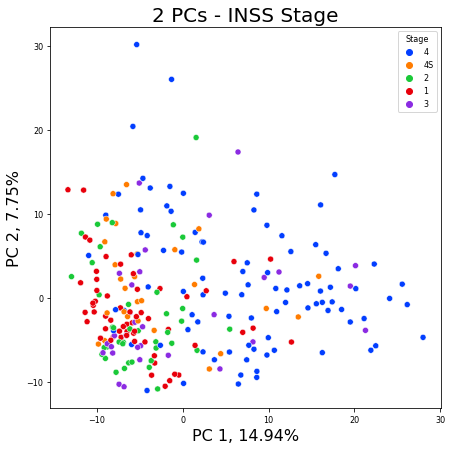

In [385]:
plt.figure(figsize = (7, 7))
ax = sns.scatterplot(x="PCA 1", y="PCA 2", hue= "Stage", data=pca_df_INSS, palette="bright")
plt.title("2 PCs - INSS Stage", fontsize=20)
plt.xlabel(pca1lab, fontsize=16)
plt.ylabel(pca2lab, fontsize=16)

## Hierarchical Clustering from SciPy (Agglomerative)
 - Unsupervised learning method for clustering data points
 - Builds clusters by measuring the dissimilarities between data
 - Begins by treating each data point as its own cluster - 'bottom up' approach
 - Then joins clusters together that have the shortest distance between them to create larger clusters
 - Ward linkage method attempts to minimise the variance between the clusters
 - The bigger the difference in vertical lines in the dendrogram, the bigger the distance is between those clusters
 - X-axis contains samples, y-axis represents the distance between these samples
 - Number of clusters can be defined by setting a threshold
 - If we set the threshold at 150 in this example, we would have 2 clusters

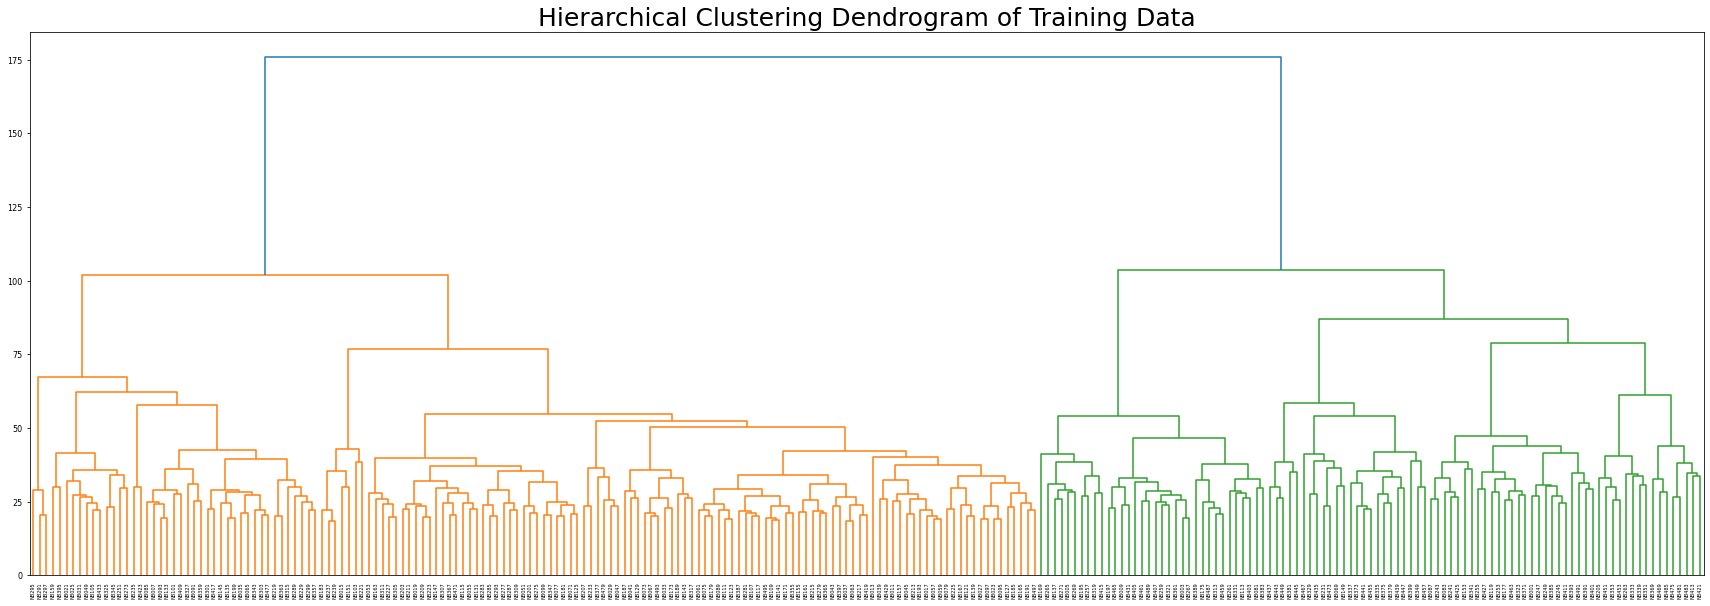

In [387]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X_train_scaled, 'ward')

plt.figure(figsize = (30, 10))
plt.title("Hierarchical Clustering Dendrogram of Training Data", fontsize=25)
dendrogram(linked,
            orientation='top',
            labels=X_train_scaled.index,
            show_leaf_counts=True)
            
plt.show()

## Hierarchical Clustering from sklearn (Agglomerative)
 - A simple visualisation of the data with a scatter plot can provide insights into whether your data is well suited for clustering or not
 - If clustering fails to producde any new of useful insights into the data, then your data is not well suited for clustering
 - Often if you have class labels, it does not make much sense to do a clustering analysis as it may not perform as well as the original class label
 - Slight variations in data could lead to high variance
 - Clusters are assumed to be spherical and evnly sized, which can reduce accuracy

### Performing Hierarchial Clustering on 2 randomly selected genes and comparing to ground truth
 - Comparing with ground truth is an external measure, we can do this as we have enough labels for the data
 - Apart from accuracy, this can be measured by using V-measure which considers homogeneity and completeness (consideration for future projects)
 - Again, clustering algorithms will perform worse than classification methods. this is just for visualisation

ID,NB497,NB495,NB493,NB491,NB489,NB487,NB485,NB483,NB481,NB479,...,NB019,NB017,NB015,NB013,NB011,NB009,NB007,NB005,NB003,NB001
Actual,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,1
Predicted,0,0,0,1,0,1,1,1,1,1,...,1,0,0,0,0,0,0,1,1,1


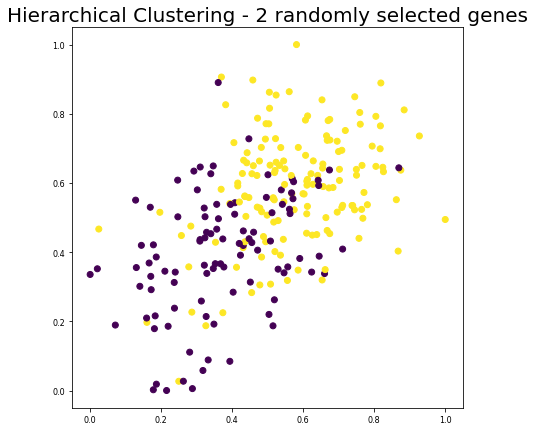

In [388]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
labels = cluster.fit_predict(X_train_scaled)

plt.figure(figsize=(7, 7))  
plt.title("Hierarchical Clustering - 2 randomly selected genes", fontsize=20)
plt.scatter(X_train_scaled['C6orf204'], X_train_scaled['TRERF1'], c=cluster.labels_)

clustering_predictions=pd.DataFrame({'Actual':y_train, 'Predicted':labels})
clustering_predictions.T

In [389]:
accuracy_2genes = np.sum(labels==y_train)/len(y_train)
accuracy_2genes

0.5060240963855421

### Performing Hierarchical Clustering on Principal Components (HCPC) and comparing to ground truth
 - Note: to improve initial partition obtained from hierarchical clustering, the final partioning solution can be obtained after consolidation with k-means (consideration for future projects)

ID,NB497,NB495,NB493,NB491,NB489,NB487,NB485,NB483,NB481,NB479,...,NB019,NB017,NB015,NB013,NB011,NB009,NB007,NB005,NB003,NB001
Actual,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,1
Predicted,0,1,1,0,1,0,0,0,0,0,...,0,1,0,1,0,1,1,0,0,0


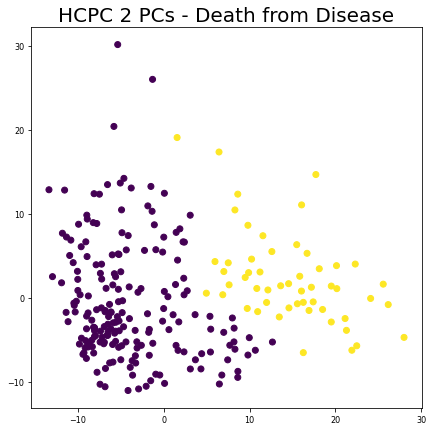

In [390]:
cluster_PCA = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
labels_PCA = cluster_PCA.fit_predict(df_rnaseq_pca)

plt.figure(figsize=(7, 7))
plt.title("HCPC 2 PCs - Death from Disease", fontsize=20)
plt.scatter(df_rnaseq_pca['PCA 1'], df_rnaseq_pca['PCA 2'], c=cluster_PCA.labels_)

clustering_predictions_PCA=pd.DataFrame({'Actual':y_train, 'Predicted':labels_PCA})
clustering_predictions_PCA.T

In [391]:
accuracy_PCA = np.sum(labels_PCA==y_train)/len(y_train)
accuracy_PCA

0.606425702811245

### HCPC on multi-class data

ID,NB497,NB495,NB493,NB491,NB489,NB487,NB485,NB483,NB481,NB479,...,NB019,NB017,NB015,NB013,NB011,NB009,NB007,NB005,NB003,NB001
Actual,1,1,1,4,4,4,3,1,4,1,...,1,2,4,4,2,4S,4,4,4,4
Predicted,1,0,0,4,0,4,2,2,2,2,...,2,0,3,0,3,0,0,2,2,2


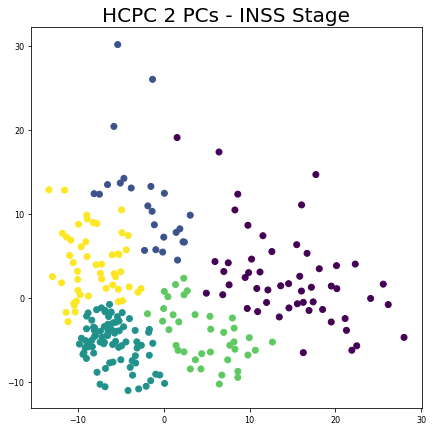

In [392]:
cluster_INSS = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
labels_INSS = cluster_INSS.fit_predict(df_rnaseq_pca)

plt.figure(figsize=(7, 7))
plt.title("HCPC 2 PCs - INSS Stage", fontsize=20)
plt.scatter(df_rnaseq_pca['PCA 1'], df_rnaseq_pca['PCA 2'], c=cluster_INSS.labels_)

clustering_predictions_INSS=pd.DataFrame({'Actual':y_train_INSS, 'Predicted':labels_INSS})
clustering_predictions_INSS.T

# 6. Feature Selection
## Unsupervised
 - Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
 - Improves Accuracy: Less misleading data means modeling accuracy improves.
 - Reduces Training Time: Less data means that algorithms train faster.



### Variance Threshold
 - Visualising variation prior to threshold filter
 - Create new dataframe of features with variance >= 0.03
 - Visualising variation after threshold filter


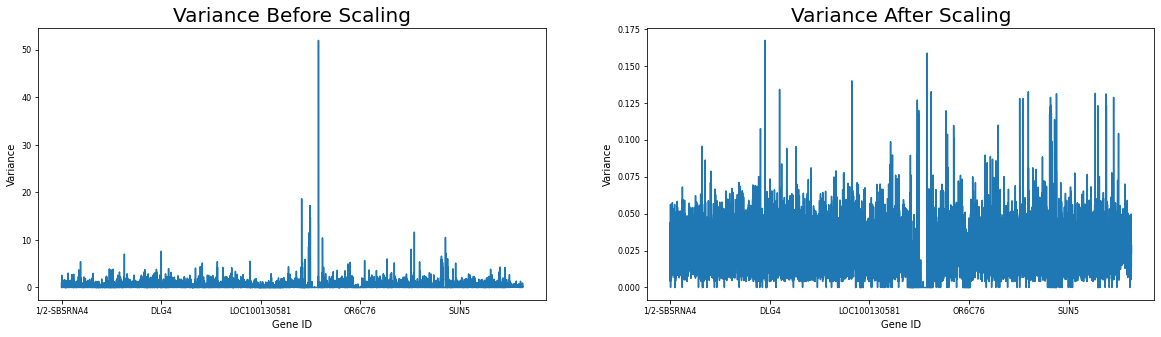

In [393]:
#Plotting variation before threshold
plt.figure(figsize = (20,5))


plt.subplot(1, 2, 1)
plt.title("Variance Before Scaling", fontsize=20)
X_train.var().plot()
plt.xlabel('Gene ID')
plt.ylabel('Variance')
plt.rc('font', size=8)
plt.rc('axes', titlesize=8)    
plt.rc('axes', labelsize=10)
plt.rc('figure', titlesize=12)

plt.subplot(1, 2, 2)
plt.title("Variance After Scaling", fontsize=20)
X_train_scaled.var().plot()
plt.xlabel('Gene ID')
plt.ylabel('Variance')
plt.rc('font', size=8)
plt.rc('axes', titlesize=8)    
plt.rc('axes', labelsize=10)
plt.rc('figure', titlesize=12)

In [394]:
variance = X_train_scaled.var()
columns = X_train_scaled.columns

newcols = []

for i in range(0,len(variance)):
    if variance[i]>=0.03:
        newcols.append(columns[i])

X_train_var = X_train_scaled[newcols]
X_train_var

gene_id,A2MP1,A4GALT,AACSP1,AARSD1,AASDHPPT,ABAT,ABCA1,ABCA12,ABCA5,ABCA7,...,ZRSR2,ZSCAN12P1,ZSCAN20,ZSCAN22,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZWILCH,ZWINT
ID,,,,,,,,,,,,,,,,,,,,,
NB001,0.402734,0.464802,0.621243,0.440065,0.170458,0.612220,0.498720,0.001321,0.834323,0.694174,...,0.333943,0.518062,0.614699,0.809709,0.761300,0.833037,0.654305,0.849847,0.680823,0.803613
NB003,0.106857,0.278144,0.794544,0.724524,0.772094,0.531845,0.221800,0.439021,0.517842,0.255194,...,0.455231,0.694030,0.150491,0.731571,0.570968,0.707347,0.672227,0.335327,0.644213,0.728846
NB005,0.000000,0.469026,0.433392,0.612324,0.616210,0.304291,0.358627,0.583517,0.449563,0.468361,...,0.519684,0.651988,0.134868,0.696353,0.457586,0.615351,0.698263,0.210786,0.656793,0.739205
NB007,0.495838,0.598279,0.815800,0.610975,0.372099,0.482942,0.473665,0.005252,0.748787,0.486039,...,0.388905,0.383269,0.216562,0.528811,0.358076,0.440602,0.514722,0.562544,0.619109,0.564315
NB009,0.000000,0.414112,0.155479,0.645082,0.869390,0.583092,0.294119,0.204151,0.478359,0.455737,...,0.841480,0.537399,0.054696,0.256701,0.919457,0.686738,0.899488,0.321101,0.656143,0.837826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NB489,0.126586,0.250251,0.786582,0.394373,0.391854,0.433531,0.455189,0.806041,0.657080,0.059225,...,0.424066,0.736504,0.483246,1.000000,0.705781,0.616988,0.671413,0.351602,0.405442,0.644552
NB491,0.000000,0.304162,0.656923,0.823683,0.382533,0.513379,0.503139,0.008951,0.005049,0.293690,...,0.470285,0.532710,0.654695,0.222040,0.947774,0.619252,0.400630,0.933763,0.722848,1.000000
NB493,0.118876,0.242578,0.651676,0.476262,0.635114,0.487233,0.236901,0.686789,0.783807,0.520681,...,0.258886,0.763998,0.433004,0.507363,0.511601,0.356622,0.505892,0.764526,0.647244,0.573598


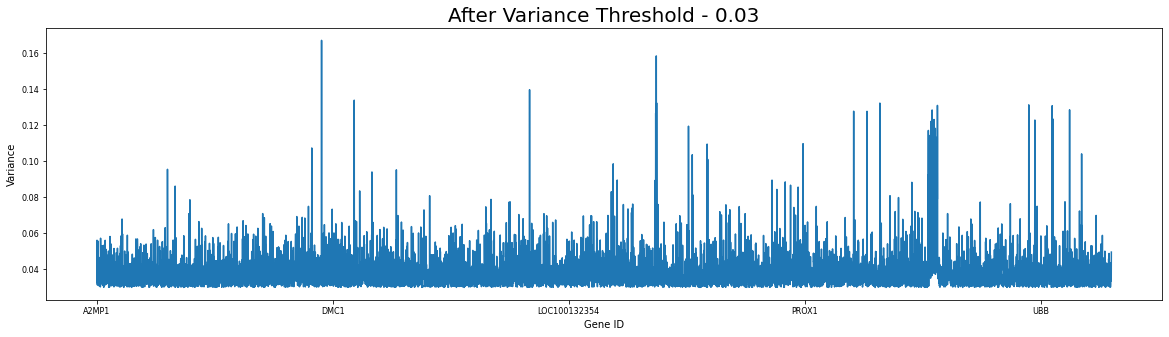

In [395]:
plt.figure(figsize = (20,5))

X_train_var.var().plot()
plt.title("After Variance Threshold - 0.03", fontsize=20)
plt.xlabel('Gene ID')
plt.ylabel('Variance')
plt.rc('font', size=8)
plt.rc('axes', titlesize=8)    
plt.rc('axes', labelsize=10)
plt.rc('figure', titlesize=12)

### Correlation
 - In many datasets we find some of the features which are highly correlated that means they are some what linearly dependent with other features
 - These features contribute very less in predicting the output but increses the computational cost
 - This takes about 15 minutes to run!

In [396]:
correlated_features = set()
correlation_matrix = X_train_var.corr()

In [397]:
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [398]:
#Dataframe with highly correlated variables removed
X_train_var_corr = X_train_var.drop(correlated_features, axis =1)
X_train_var_corr

gene_id,A2MP1,A4GALT,AACSP1,AARSD1,AASDHPPT,ABAT,ABCA1,ABCA12,ABCA5,ABCA7,...,ZRANB3,ZRSR2,ZSCAN12P1,ZSCAN20,ZSCAN22,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZWILCH
ID,,,,,,,,,,,,,,,,,,,,,
NB001,0.402734,0.464802,0.621243,0.440065,0.170458,0.612220,0.498720,0.001321,0.834323,0.694174,...,0.319924,0.333943,0.518062,0.614699,0.809709,0.761300,0.833037,0.654305,0.849847,0.680823
NB003,0.106857,0.278144,0.794544,0.724524,0.772094,0.531845,0.221800,0.439021,0.517842,0.255194,...,0.764969,0.455231,0.694030,0.150491,0.731571,0.570968,0.707347,0.672227,0.335327,0.644213
NB005,0.000000,0.469026,0.433392,0.612324,0.616210,0.304291,0.358627,0.583517,0.449563,0.468361,...,0.585340,0.519684,0.651988,0.134868,0.696353,0.457586,0.615351,0.698263,0.210786,0.656793
NB007,0.495838,0.598279,0.815800,0.610975,0.372099,0.482942,0.473665,0.005252,0.748787,0.486039,...,0.297256,0.388905,0.383269,0.216562,0.528811,0.358076,0.440602,0.514722,0.562544,0.619109
NB009,0.000000,0.414112,0.155479,0.645082,0.869390,0.583092,0.294119,0.204151,0.478359,0.455737,...,0.525395,0.841480,0.537399,0.054696,0.256701,0.919457,0.686738,0.899488,0.321101,0.656143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NB489,0.126586,0.250251,0.786582,0.394373,0.391854,0.433531,0.455189,0.806041,0.657080,0.059225,...,0.613538,0.424066,0.736504,0.483246,1.000000,0.705781,0.616988,0.671413,0.351602,0.405442
NB491,0.000000,0.304162,0.656923,0.823683,0.382533,0.513379,0.503139,0.008951,0.005049,0.293690,...,0.420406,0.470285,0.532710,0.654695,0.222040,0.947774,0.619252,0.400630,0.933763,0.722848
NB493,0.118876,0.242578,0.651676,0.476262,0.635114,0.487233,0.236901,0.686789,0.783807,0.520681,...,0.437379,0.258886,0.763998,0.433004,0.507363,0.511601,0.356622,0.505892,0.764526,0.647244


## Supervised
### Select K Best - Binary

In [400]:
X_top = SelectKBest(k=150)
fit = X_top.fit_transform(X_train_var_corr, y_train)

cols = X_top.get_support(indices=True)
Xtrain = X_train_var_corr.iloc[:,cols]
Xtrain

gene_id,AIP,ALS2CR8,ANKDD1A,ANKFY1,APOO,ARC,ARGLU1,ARHGAP21,ARID1A,ARL13A,...,USP24,VPS13C,WDR74,WIPF2,YIF1A,YPEL1,ZMYM6,ZNF609,ZNF624,ZNF800
ID,,,,,,,,,,,,,,,,,,,,,
NB001,0.620037,0.736759,0.748933,0.669697,0.338108,0.292013,0.636730,0.331756,0.943463,0.440897,...,0.614485,0.518798,0.530900,0.696504,0.566022,0.664985,0.746334,0.644940,0.402405,0.989155
NB003,0.546487,0.532923,0.234430,0.338251,0.629119,0.742696,0.592044,0.531385,0.410680,0.228999,...,0.229110,0.303783,0.691639,0.411970,0.526983,0.530296,0.366946,0.569056,0.485365,0.316309
NB005,0.341449,0.508966,0.328374,0.384532,0.553327,0.466012,0.454181,0.426086,0.272508,0.126769,...,0.088283,0.284659,0.548412,0.467693,0.614638,0.367553,0.319869,0.325336,0.338757,0.257057
NB007,0.358634,0.524629,0.636633,0.463562,0.364686,0.400449,0.519420,0.690680,0.788244,0.440503,...,0.536345,0.485447,0.479770,0.642571,0.619504,0.425298,0.577130,0.536638,0.422821,0.574173
NB009,0.585636,0.437753,0.368878,0.284710,0.590554,0.416225,0.479091,0.248695,0.389853,0.173842,...,0.005383,0.205472,0.753726,0.411704,0.630814,0.501972,0.231528,0.482126,0.468960,0.357885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NB489,0.605160,0.365693,0.335195,0.412247,0.426230,0.745020,0.351216,0.286908,0.351627,0.136993,...,0.270533,0.242369,0.708428,0.305803,0.448081,0.515759,0.276048,0.584823,0.378270,0.273902
NB491,0.773978,0.579644,0.359177,0.470316,0.597588,0.472482,0.488672,0.446787,0.994621,0.206615,...,0.712400,0.396969,0.871309,0.873835,0.897265,0.537032,0.674675,0.476415,0.449397,0.573919
NB493,0.024784,0.597573,0.671660,0.757860,0.449239,0.481015,0.647500,0.789934,0.798250,0.000000,...,0.611947,0.570531,0.240453,0.849709,0.191386,0.782280,0.682728,0.810562,0.770529,0.684500


### Select K Best - Multiclass

In [401]:
X_top_m = SelectKBest(k=150)
fit_m = X_top_m.fit_transform(X_train_var_corr, y_train_INSS)

cols_m = X_top_m.get_support(indices=True)
Xtrain_m = X_train_var_corr.iloc[:,cols_m]
Xtrain_m

gene_id,ADAMTS6,AGAP5,APOO,ARL6IP1,ATP5B,ATP5D,ATP5F1,ATP5G3,ATP5I,ATP5J,...,UBE2N,UBL5,UBXN6,UQCRFS1,VBP1,VKORC1,VPS72,VSIG2,WDR25,ZNF771
ID,,,,,,,,,,,,,,,,,,,,,
NB001,0.403716,0.787442,0.338108,0.540926,0.376497,0.502315,0.378850,0.270396,0.065384,0.266846,...,0.216797,0.312790,0.272881,0.433987,0.413848,0.393097,0.246462,0.121919,0.187528,0.240561
NB003,0.240353,0.684757,0.629119,0.536228,0.519621,0.684696,0.454550,0.348937,0.494177,0.585216,...,0.408162,0.349649,0.540130,0.685175,0.443486,0.470699,0.436937,0.152254,0.529035,0.551344
NB005,0.609356,0.766222,0.553327,0.600277,0.430364,0.578069,0.359955,0.322176,0.589677,0.624825,...,0.435623,0.503767,0.349335,0.608809,0.454416,0.601760,0.304228,0.253081,0.366747,0.390278
NB007,0.215828,0.751153,0.364686,0.475217,0.227096,0.443525,0.366787,0.277871,0.318928,0.280991,...,0.375244,0.313028,0.356705,0.490176,0.424101,0.388491,0.329905,0.229756,0.304416,0.278629
NB009,0.239692,0.637197,0.590554,0.576088,0.634844,0.713396,0.522194,0.458984,0.571408,0.584702,...,0.422510,0.492912,0.420767,0.679619,0.547872,0.643516,0.547358,0.099557,0.476320,0.606043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NB489,0.098237,0.808574,0.426230,0.468190,0.594692,0.605010,0.400026,0.303348,0.502029,0.470214,...,0.326196,0.311245,0.411499,0.599364,0.302313,0.466951,0.410976,0.111051,0.427072,0.462456
NB491,0.170232,0.689450,0.597588,0.729361,0.705834,0.571589,0.518213,0.472224,0.502421,0.447886,...,0.526331,0.435338,0.342381,0.552861,0.583272,0.592837,0.494262,0.040827,0.513866,0.252683
NB493,0.401987,0.713543,0.449239,0.567177,0.341473,0.314333,0.316269,0.325896,0.337190,0.386329,...,0.619057,0.208527,0.460341,0.517735,0.340988,0.150493,0.361818,0.168327,0.188807,0.325018


## Visualising Top 150 Features
 - We can see from the heatmap that our none of our top 30 features are highly correlated
 - Dendrogram (binary) shows more obvious cluster cut off point

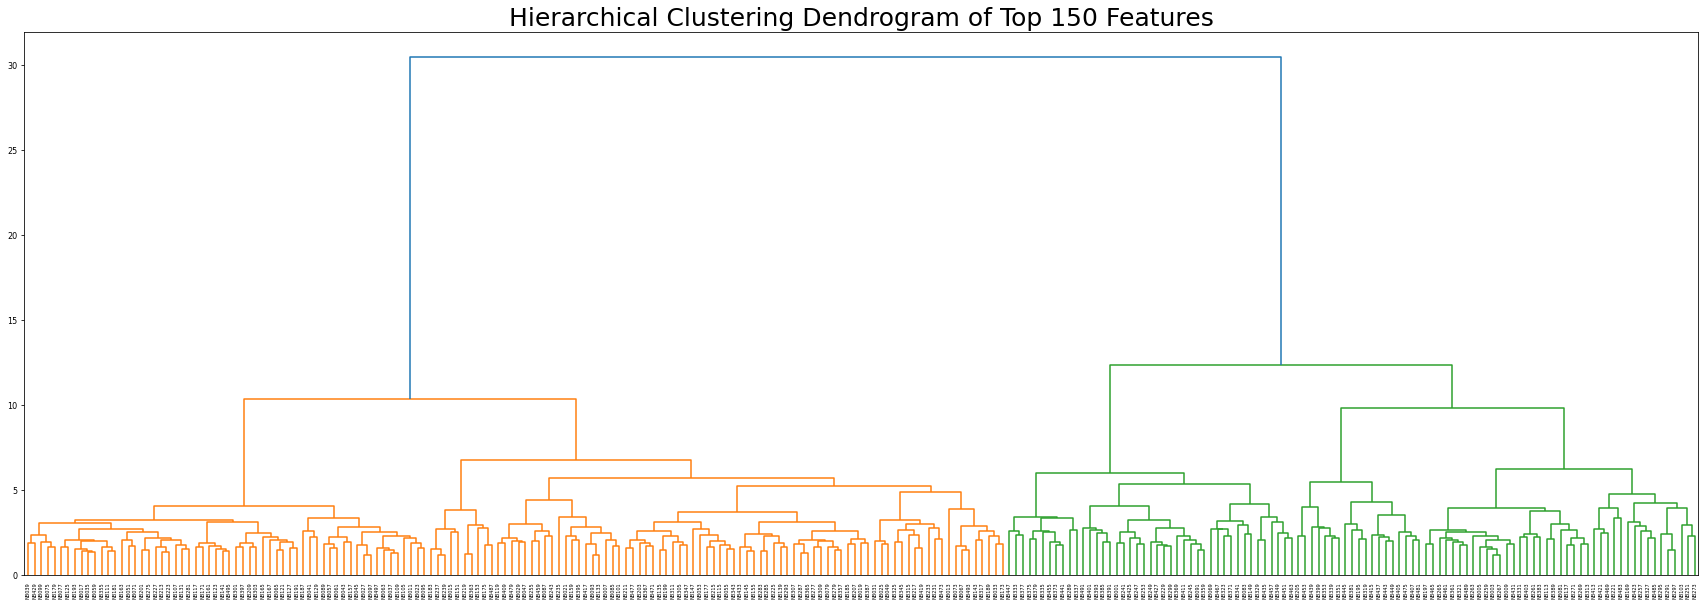

In [402]:
linked20 = linkage(Xtrain, 'ward')

plt.figure(figsize = (30, 10))
plt.title("Hierarchical Clustering Dendrogram of Top 150 Features", fontsize=25)
dendrogram(linked20,
            orientation='top',
            labels=X_train_scaled.index,
            show_leaf_counts=True)
            
plt.show()

<AxesSubplot:title={'center':'Heatmap for Top 30 Features'}, xlabel='gene_id', ylabel='gene_id'>

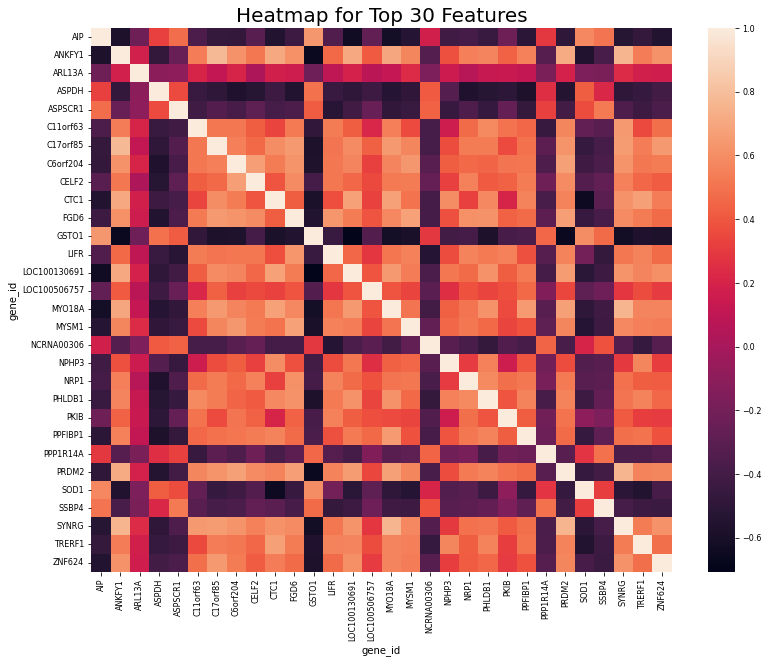

In [403]:
X_top30 = SelectKBest(k=30)
fit30 = X_top30.fit_transform(X_train_var_corr, y_train)
cols30 = X_top30.get_support(indices=True)
Xtrain30 = X_train_var_corr.iloc[:,cols30]

correlation_matrix30 = Xtrain30.corr()

plt.figure(figsize = (13, 10))
plt.title("Heatmap for Top 30 Features", fontsize=20)
sns.heatmap(correlation_matrix30, 
        xticklabels=correlation_matrix30.columns,
        yticklabels=correlation_matrix30.columns)

### Matching features from Xtrain (with top 150) to X_test (binary)

In [404]:
X_top_cols = Xtrain.columns
X_test_cols = X_test.columns
X_top_list = X_top_cols.tolist()
X_test_list = X_test_cols.tolist()
differences = list(set(X_top_list).symmetric_difference(set(X_test_list)))

In [405]:
Xtest = X_test.drop(differences, axis =1)
Xtest

gene_id,AIP,ALS2CR8,ANKDD1A,ANKFY1,APOO,ARC,ARGLU1,ARHGAP21,ARID1A,ARL13A,...,USP24,VPS13C,WDR74,WIPF2,YIF1A,YPEL1,ZMYM6,ZNF609,ZNF624,ZNF800
ID,,,,,,,,,,,,,,,,,,,,,
NB002,4.572684,2.229090,1.247040,4.287760,3.783907,2.260778,6.429430,5.095891,5.298211,0.055619,...,2.905251,2.437454,3.662889,3.446741,3.934092,4.391623,2.157713,3.468362,2.153598,2.694002
NB004,5.317926,2.052990,2.419453,3.753455,3.684336,1.483148,5.998335,4.492520,4.179575,0.000000,...,2.904607,2.547492,3.867778,3.710184,4.898503,4.622772,1.876692,3.794738,1.850559,1.721806
NB006,4.719112,2.584748,2.619606,5.292587,2.950543,3.407355,6.579050,5.776009,5.277914,0.144580,...,3.429915,3.040856,3.664745,4.207432,4.352088,4.535481,2.472940,3.887155,2.361182,3.171897
NB008,5.252885,1.988834,2.247745,3.109778,3.259893,3.830438,4.734336,4.456609,4.164473,0.038682,...,2.445549,2.394591,4.736491,3.138416,4.849794,3.785498,1.741558,3.873626,1.448922,1.883472
NB010,5.511775,1.983995,1.552067,3.231756,3.564207,3.581098,6.124276,3.996795,4.357531,0.065212,...,3.192159,2.258793,4.945093,3.275491,4.747022,4.116514,2.028965,4.120725,1.474192,1.557415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NB490,5.808717,1.386397,1.959733,3.663208,3.869960,2.884166,6.043651,3.812211,3.149401,0.000000,...,2.532746,2.684325,5.099952,3.004696,5.615078,3.237224,1.291609,3.561448,1.006384,1.543600
NB492,5.523609,2.155140,1.831306,3.593892,3.098854,4.370890,6.019758,4.133070,3.729531,0.000000,...,2.502448,2.280772,4.805690,3.030620,4.530352,4.388196,2.011707,3.503858,1.524916,1.692726
NB494,4.808648,2.060002,2.967298,4.479657,2.897401,1.223830,7.427372,5.672929,4.855830,0.000000,...,3.203824,3.549226,3.528809,3.625177,4.318483,5.186726,2.369980,3.876203,1.711261,2.312049


### Matching features from Xtrain_m (with top 150) to X_test (multi)

In [406]:
X_top_cols_m = Xtrain_m.columns
X_test_cols_m = X_test.columns
X_top_list_m = X_top_cols_m.tolist()
X_test_list_m = X_test_cols_m.tolist()
differences = list(set(X_top_list_m).symmetric_difference(set(X_test_list_m)))

In [407]:
Xtestm = X_test.drop(differences, axis =1)
Xtestm

gene_id,ADAMTS6,AGAP5,APOO,ARL6IP1,ATP5B,ATP5D,ATP5F1,ATP5G3,ATP5I,ATP5J,...,UBE2N,UBL5,UBXN6,UQCRFS1,VBP1,VKORC1,VPS72,VSIG2,WDR25,ZNF771
ID,,,,,,,,,,,,,,,,,,,,,
NB002,0.250137,2.567154,3.783907,7.378147,7.887958,5.810438,4.843456,4.673879,7.266543,5.482571,...,5.421907,7.631919,5.176311,5.435229,5.500541,5.502770,5.590392,0.110181,2.468234,2.912642
NB004,0.050897,2.406286,3.684336,6.937803,7.936120,6.030958,5.458825,4.961193,7.206311,5.815068,...,5.130288,7.180446,5.214370,5.587209,5.275462,5.436462,5.049047,0.182714,2.466473,2.766989
NB006,0.105576,2.435314,2.950543,6.939920,8.333621,5.543944,4.981113,5.111365,6.640423,5.404879,...,5.276299,6.549678,4.816006,5.245971,5.085463,5.078473,4.479134,0.155495,1.928067,1.755764
NB008,0.153939,1.715885,3.259893,6.670770,8.211942,6.184820,5.412423,4.944634,7.165007,5.735292,...,5.020120,6.783169,4.771389,5.701937,5.074604,5.678083,5.139699,0.297132,2.083186,2.628706
NB010,0.121976,2.265845,3.564207,6.828467,8.322739,6.256494,5.759129,5.147018,7.453740,6.003467,...,5.338521,7.040651,5.204868,5.669222,5.277907,5.893394,5.479318,0.180922,2.793072,2.714588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NB490,0.241306,2.401267,3.869960,6.560637,9.131018,7.036196,5.861318,5.948379,8.263086,6.457780,...,5.216292,7.991919,5.682885,6.618824,4.888164,6.798802,5.813219,0.314947,2.630711,2.793680
NB492,0.272940,2.966707,3.098854,7.203563,7.917330,6.026222,4.570281,4.741240,7.339066,5.800214,...,4.914823,6.873420,5.227533,5.378356,4.630895,6.063652,5.177272,0.237140,2.425706,2.764803
NB494,0.117136,2.698930,2.897401,6.820141,7.757597,5.598294,5.261614,4.874836,6.347882,5.327626,...,5.101020,6.730993,4.820812,4.882418,4.850349,5.134669,4.955596,0.650064,1.868244,2.199547


# 6. Choosing a Model, Evaluating Performance with KFold CV and Parameter Search

 - I should have chose LogisticRegression. It was always performing best with whichever scoring metric I had.
 - Honestly speaking, I just kept getting errors with the parameter search and max_iter
 - I decided to opt for RandomForest, I knew how it worked and based on what we have learnt, it is a good option for binary and multi-class
 - For future projects I would like to focus on increasing these scores as it seems a good score should be 0.85 and up

### Models

In [408]:
models = []
models.append(('Logistic Regression', LogisticRegression(max_iter=1000)))
models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
models.append(('K Nearest Neighbour', KNeighborsClassifier()))
models.append(('Desicion Tree Classifier', DecisionTreeClassifier()))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('SVM', SVC()))
models.append(('Gradient Boost', GradientBoostingClassifier()))

In [410]:
num_folds = 10
seed = 1
scoring = make_scorer(roc_auc_score, greater_is_better=True)

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, Xtrain, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)


binary_results = pd.DataFrame(results, index = [names])
binary_results['Mean Cross Validation ROCAUC Score'] = binary_results.mean(axis=1)
binary_results.round(decimals=2)
binary_results.drop(binary_results.iloc[:,0:10],inplace=True,axis=1)
binary_results

,Mean Cross Validation ROCAUC Score
Logistic Regression,0.595427
Linear Discriminant Analysis,0.557574
K Nearest Neighbour,0.600801
Desicion Tree Classifier,0.524055
Gaussian Naive Bayes,0.636693
Random Forest,0.533321
SVM,0.510000
Gradient Boost,0.540466


### Multi-class

In [411]:
scorer = make_scorer(f1_score, greater_is_better=True, average='weighted')

results_multi = []
names_multi = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results_multi = cross_val_score(model, Xtrain_m, y_train_INSS, cv=kfold, scoring=scorer)
    results_multi.append(cv_results_multi)
    names_multi.append(name)

multi_results = pd.DataFrame(results_multi, index = [names_multi])
multi_results['Mean Cross Validation f1 Score'] = multi_results.mean(axis=1)
multi_results.round(decimals=2)

,0,1,2,3,4,5,6,7,8,9,Mean Cross Validation f1 Score
Logistic Regression,0.50,0.47,0.43,0.53,0.40,0.48,0.29,0.47,0.44,0.49,0.45
Linear Discriminant Analysis,0.41,0.38,0.28,0.39,0.32,0.17,0.14,0.22,0.39,0.27,0.30
K Nearest Neighbour,0.31,0.59,0.41,0.49,0.31,0.37,0.26,0.47,0.40,0.26,0.39
Desicion Tree Classifier,0.25,0.44,0.32,0.35,0.24,0.27,0.27,0.24,0.33,0.25,0.30
Gaussian Naive Bayes,0.52,0.42,0.44,0.43,0.36,0.36,0.39,0.51,0.41,0.38,0.42
Random Forest,0.35,0.47,0.37,0.42,0.35,0.27,0.19,0.43,0.35,0.21,0.34
SVM,0.38,0.39,0.43,0.43,0.34,0.23,0.19,0.38,0.46,0.25,0.35
Gradient Boost,0.45,0.56,0.41,0.40,0.32,0.39,0.25,0.47,0.44,0.23,0.39


### Why are CV scores so low for multi-class?

 - Accuracy scores only make sense as a metric if youre labels are balanced (why I decided not to use)
 - We can see that the distribution of labels is not even, could this be why?
 - We know that Random Forest can be used for multi-classification and inherently performs well
 - Regardless of the scores, we will try to make accurate predications using Random Forest
 - We can try to increase the accuracy by getting the best parameters for the model

## Getting Parameters for Random Forest

In [413]:
parameters = {
    'n_estimators': [2,8,32,128,256], 
    'max_depth':[2,4,6,8,16],
    'min_samples_leaf':[2,4,6,8,16],
}

random_f_model = RandomForestClassifier() 

#binary grid search
rf_grid_search = GridSearchCV(random_f_model, parameters, cv=10,scoring=scoring) 
grid_search_death = rf_grid_search.fit(Xtrain, y_train)
grid_search_highrisk = rf_grid_search.fit(Xtrain, y_train_highrisk)
grid_search_prog = rf_grid_search.fit(Xtrain, y_train_prog)


#multigrid search
rf_grid_search_multi = GridSearchCV(random_f_model, parameters, cv=10,scoring=scorer)
grid_search_multi = rf_grid_search_multi.fit(Xtrain, y_train_INSS)

In [416]:
best_model_death = grid_search_binary.best_estimator_  

best_model_highrisk = grid_search_highrisk.best_estimator_ 

best_model_prog = grid_search_prog.best_estimator_ 

best_model_multi = grid_search_multi.best_estimator_  

# 8. Predictions
### Scale Test Data
 - First we need to scale the test data, as we did to the training data
 - This is done seperately to avoid any data leakage

In [417]:
scaler.fit_transform(Xtest)
Xtest_scale = pd.DataFrame(scaler.fit_transform(Xtest.values),
                              columns=Xtest.columns,index=Xtest.index)

In [418]:
scaler.fit_transform(Xtestm)
Xtest_scalem = pd.DataFrame(scaler.fit_transform(Xtestm.values),
                              columns=Xtestm.columns,index=Xtestm.index)

### Death from Disease Predictions
 - Counts for actual labels have been done to give a very vague idea of what to expect
 - This is in no way a means of ensuring accuracy
 - It is simply a way to perhaps determine if something has gone very wrong during predictions

In [419]:
best_model_death.fit(Xtrain, y_train)
y_predict=best_model_death.predict(Xtest_scale)
y_prob = best_model_death.predict_proba(Xtest_scale)

In [420]:
cols = ['DeathFromDisease0', 'DeathFromDisease1']
results = pd.DataFrame(data = y_prob, index = Xtest_scale.index, columns = cols)
results['DeathFromDiseasePredicted'] = y_predict
results

,DeathFromDisease0,DeathFromDisease1,DeathFromDiseasePredicted
ID,,,
NB002,0.850691,0.149309,0
NB004,0.887617,0.112383,0
NB006,0.554240,0.445760,0
NB008,0.918076,0.081924,0
NB010,0.912143,0.087857,0
...,...,...,...
NB490,0.909960,0.090040,0
NB492,0.882506,0.117494,0
NB494,0.639015,0.360985,0


In [421]:
counts_dfd = df_patient_info_train['FactorValue..death.from.disease.'].value_counts(normalize=True)

### High risk (Clinically considered as high-risk neuroblastoma) Predictions

In [422]:
best_model_highrisk.fit(Xtrain, y_train_highrisk)
y_predict_highrisk=best_model_highrisk.predict(Xtest_scale)
y_prob_highrisk = best_model_highrisk.predict_proba(Xtest_scale)

In [423]:
cols_highrisk = ['HighRisk0', 'HighRisk1']
results_highrisk = pd.DataFrame(data = y_prob_highrisk, index = Xtest_scale.index, columns = cols_highrisk)
results_highrisk['HighRiskPredicted'] = y_predict_highrisk
results_highrisk

,HighRisk0,HighRisk1,HighRiskPredicted
ID,,,
NB002,0.665041,0.334959,0
NB004,0.796480,0.203520,0
NB006,0.477557,0.522443,1
NB008,0.714508,0.285492,0
NB010,0.721021,0.278979,0
...,...,...,...
NB490,0.887062,0.112938,0
NB492,0.747949,0.252051,0
NB494,0.481116,0.518884,1


In [424]:
counts_hr = df_patient_info_train['FactorValue..high.risk.'].value_counts(normalize=True)

### Progression (Occurrence of a tumor progression event) Predictions

In [425]:
best_model_prog.fit(Xtrain, y_train_prog)
y_predict_prog=best_model_prog.predict(Xtest_scale)
y_prob_prog = best_model_prog.predict_proba(Xtest_scale)

In [426]:
cols_prog = ['Progression0', 'Progression1']
results_prog = pd.DataFrame(data = y_prob_prog, index = Xtest_scale.index, columns = cols_prog)
results_prog['ProgressionPredicted'] = y_predict_prog
results_prog

,Progression0,Progression1,ProgressionPredicted
ID,,,
NB002,0.638834,0.361166,0
NB004,0.748917,0.251083,0
NB006,0.441056,0.558944,1
NB008,0.624936,0.375064,0
NB010,0.719787,0.280213,0
...,...,...,...
NB490,0.799590,0.200410,0
NB492,0.597407,0.402593,0
NB494,0.490137,0.509863,1


In [427]:
counts_prog = df_patient_info_train['FactorValue..progression.'].value_counts(normalize=True)

### INSS stage (Disease stage according to International Neuroblastoma Staging System) Predictions

In [428]:
best_model_multi.fit(Xtrain_m, y_train_INSS)
y_predict_INSS=best_model_multi.predict(Xtest_scalem)
y_prob_INSS = best_model_multi.predict_proba(Xtest_scalem)

In [429]:
cols_INSS = ['INSS1', 'INSS2', 'INSS3', 'INSS4', 'INSS4S']
results_INSS = pd.DataFrame(data = y_prob_INSS, index = Xtest_scalem.index, columns = cols_INSS)
results_INSS['INSSPredicted'] = y_predict_INSS
results_INSS

,INSS1,INSS2,INSS3,INSS4,INSS4S,INSSPredicted
ID,,,,,,
NB002,0.137767,0.160724,0.156450,0.312602,0.232456,4
NB004,0.491219,0.219935,0.036979,0.166327,0.085539,1
NB006,0.098149,0.078283,0.191857,0.587225,0.044487,4
NB008,0.150602,0.243678,0.190179,0.337751,0.077790,4
NB010,0.139468,0.436184,0.131155,0.184710,0.108482,2
...,...,...,...,...,...,...
NB490,0.314379,0.513755,0.109848,0.023346,0.038671,2
NB492,0.298437,0.116508,0.304203,0.135487,0.145365,3
NB494,0.098827,0.194551,0.106719,0.544053,0.055850,4


In [342]:
counts = df_patient_info_train['FactorValue..inss.stage.'].value_counts(normalize=True)

In [434]:
FINAL_DF = pd.concat([results, results_prog, results_highrisk, results_INSS], axis=1)
FINAL_DF

,DeathFromDisease0,DeathFromDisease1,DeathFromDiseasePredicted,Progression0,Progression1,ProgressionPredicted,HighRisk0,HighRisk1,HighRiskPredicted,INSS1,INSS2,INSS3,INSS4,INSS4S,INSSPredicted
ID,,,,,,,,,,,,,,,
NB002,0.850691,0.149309,0,0.638834,0.361166,0,0.665041,0.334959,0,0.137767,0.160724,0.156450,0.312602,0.232456,4
NB004,0.887617,0.112383,0,0.748917,0.251083,0,0.796480,0.203520,0,0.491219,0.219935,0.036979,0.166327,0.085539,1
NB006,0.554240,0.445760,0,0.441056,0.558944,1,0.477557,0.522443,1,0.098149,0.078283,0.191857,0.587225,0.044487,4
NB008,0.918076,0.081924,0,0.624936,0.375064,0,0.714508,0.285492,0,0.150602,0.243678,0.190179,0.337751,0.077790,4
NB010,0.912143,0.087857,0,0.719787,0.280213,0,0.721021,0.278979,0,0.139468,0.436184,0.131155,0.184710,0.108482,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NB490,0.909960,0.090040,0,0.799590,0.200410,0,0.887062,0.112938,0,0.314379,0.513755,0.109848,0.023346,0.038671,2
NB492,0.882506,0.117494,0,0.597407,0.402593,0,0.747949,0.252051,0,0.298437,0.116508,0.304203,0.135487,0.145365,3
NB494,0.639015,0.360985,0,0.490137,0.509863,1,0.481116,0.518884,1,0.098827,0.194551,0.106719,0.544053,0.055850,4


In [437]:
FINAL_DF.to_csv('RnaSeqPredictions.csv')